In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from logger import logger
import os
import cv2
import pydot

import keras.backend as K
from keras import callbacks as Kcallbacks
from keras.utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Input, Activation, ZeroPadding2D, BatchNormalization,\
    Flatten, MaxPooling2D, Dropout

from tensorflow import losses as tflosses
%matplotlib inline
np.random.seed(0)

Using TensorFlow backend.


In [2]:
train = np.load('./data/train/train_dataset.npy')
labels = np.load('./data/train/labels.npy')

In [3]:
# Scaling data to standard mean and variance.
scaler0 = StandardScaler()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

train[:,:,:,0] = scaler0.fit_transform(train[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,1] = scaler1.fit_transform(train[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,2] = scaler2.fit_transform(train[:,:,:,2].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,3] = scaler3.fit_transform(train[:,:,:,3].reshape(-1,1)).reshape(-1,75,75)

scalers = (scaler0, scaler1, scaler2, scaler3)
print train.shape

(1604, 75, 75, 4)


In [4]:
def prepare_test_data() :
    global scaler0, scaler1, scaler2, scaler3
    test_dataset = np.load('./data/test/test_dataset.npy')
    test_ids = np.load('./data/test/ids.npy')

    test_dataset[:,:,:,0] = scaler0.transform(test_dataset[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,1] = scaler1.transform(test_dataset[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,2] = scaler2.transform(test_dataset[:,:,:,2].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,3] = scaler3.transform(test_dataset[:,:,:,3].reshape(-1,1)).reshape(-1,75,75)
    
    #test_dataset = test_dataset[:,:,:,2:4]
    print test_dataset.shape
    return test_dataset, test_ids

In [5]:
# DATA augmentation. from kerenel, https://www.kaggle.com/vincento/keras-starter-4l-0-1936-lb-icebergchallenge/code
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        d=imgs[i,:,:,3]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        dv=cv2.flip(d,1)
        dh=cv2.flip(d,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv, dv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch, dh)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

train = get_more_images(train)
labels = np.concatenate((labels,labels,labels))
print train.shape
print labels.shape

(4812, 75, 75, 4)
(4812, 1)


In [7]:
# getting validation set
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train, labels, test_size=.0000001)


print train_dataset.shape, train_labels.shape
print valid_dataset.shape, valid_labels.shape

del train, labels

(4811, 75, 75, 4) (4811, 1)
(1, 75, 75, 4) (1, 1)


------------------------

 ** A ship


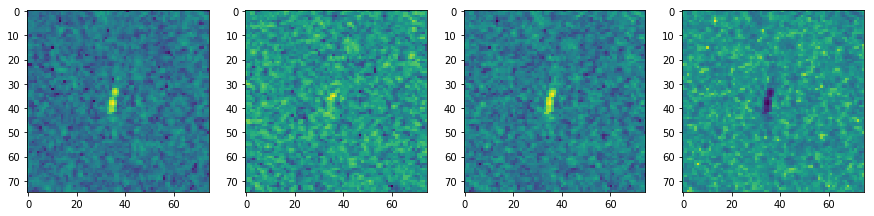

In [15]:
plt.rcParams["figure.figsize"] = [15,15]
index = np.random.randint(0, train_dataset.shape[0])
f, axarr = plt.subplots(1,4)
_ = axarr[0].imshow(train_dataset[index,:,:,0])
_ = axarr[1].imshow(train_dataset[index,:,:,1])
_ = axarr[2].imshow(train_dataset[index,:,:,2])
_ = axarr[3].imshow(train_dataset[index,:,:,3])

print " ** A ship" if train_labels[index,0] == 1 else " ** An iceberg"

In [ ]:
def convolution_layer(X, layer_name, paddings, convC, convF, convS, poolF, poolS, droprate=.2):
    X = ZeroPadding2D(paddings, name='Zero_Padding_'+layer_name)(X)
    X = Conv2D(convC, convF, strides=convS, name='Conv2d_'+layer_name)(X)
    X = BatchNormalization(axis=3, name='BN_'+layer_name)(X)
    X = Activation('relu', name='relu_activ_'+layer_name)(X)
    X = MaxPooling2D(poolF, poolS, name='MaxPooling_'+layer_name)(X)
    X = Dropout(droprate, name='dropout_'+layer_name)(X)
    return X
#--------------------------------------------------------
def fullyconnected_layer(X, layer_name, dense_units, activ, droprate=.2):
    X = Dense(dense_units, activation=activ, name='Dense_'+layer_name)(X)
    if layer_name == 'output' : return X
    X = BatchNormalization( name='BN_'+layer_name)(X)
    X = Dropout(droprate, name='dropout_'+layer_name)(X)
    return X
#-----------------------------------------------------------------------
def get_model(input_shape):
    X_input = Input(input_shape, name= 'input')
    # layer 1
    X = convolution_layer(X_input, 'layer1', 3, 64,  3, 1, 3, 2, .2)
    X = convolution_layer(X,       'layer2', 2, 128, 3, 1, 2, 2, .2)
    X = convolution_layer(X,       'layer3', 2, 128, 3, 1, 2, 2, .2)
    X = convolution_layer(X,       'layer4', 2, 64,  3, 1, 2, 2, .2)
    
    X = Flatten()(X)
    X = fullyconnected_layer(X, 'FC1', 512, 'relu', .5)
    X = fullyconnected_layer(X, 'FC2', 256, 'relu', .5)
    X = fullyconnected_layer(X, 'FC3', 256, 'relu', .5)
    X = fullyconnected_layer(X, 'output', 1, 'sigmoid')
    
    model = Model(inputs=X_input, outputs=X)
    return model
model = get_model([75,75,4])
model.summary()

In [ ]:
model.compile(Adam(), loss='binary_crossentropy',metrics=[])

In [ ]:
callbacks = [ 
    kcallbacks.EarlyStopping(patience=10, verbose=1, mode='min'),
    kcallbacks.History(),
    kcallbacks.CSVLogger('./tmp/keras/logs/logger0.log', append=True),
    kcallbacks.ReduceLROnPlateau(factor=.1, patience=7, verbose=1),
    kcallbacks.ModelCheckpoint('./tmp/keras/checkpoints/ckpt-{val_loss:.4f}-{epoch:02d}.hdf5',
                               verbose=1, save_best_only=1, mode='min')
] 

model.fit(x=train, y=labels, batch_size=32, epochs=50, shuffle=True, verbose=1, 
          validation_split=.25, callbacks=callbacks)

In [ ]:
model.evaluate(valid_dataset, valid_labels)

In [ ]:
best_model.evaluate(valid_dataset, valid_labels)

In [ ]:
def predict_test_dataset(model, subid):
    test_data, test_ids = prepare_test_data()
    test_preds = model.predict(test_data, batch_size=200, verbose=1)
    sub_df = pd.DataFrame({'id':test_ids, 'is_iceberg':test_preds.reshape((-1))})
    sub_df.to_csv('./data/submissions/submission-{}'.format(subid), index=False)

In [ ]:
predict_test_dataset(best_model, '.2021')

In [ ]:
best_model = load_model('./tmp/keras/checkpoints/ckpt-02-0.54.hdf5')

In [ ]:
plot_model(best_model, to_file='./model.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot